In [2]:
import numpy as np
import json as js
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

In [14]:
#load data

base_dir = "C:\\Users\\1\\Desktop\\datasets"

def data_loader(base_dir, max_data, start_position=0):

    data_buffer = {}

    for json_file in os.listdir(base_dir)[:-1]:


        curent_file = os.path.join(base_dir, json_file)
        curent_data_buffer = {}
        with open (curent_file) as file:

            json_data = file.readlines()
            json_data = json_data[start_position:]

            for (json_number, json_per_line) in enumerate(json_data):
                
                if json_number == max_data:
                
                    break

                json_format = js.loads(json_per_line)
                curent_data_buffer[f"subject_number: {json_number}"] = json_format
        
        data_buffer[json_file] = curent_data_buffer


    person_id_list = []
    for data_batch in data_buffer.keys():
        for subject in data_buffer[data_batch].keys():

            person_id_list.append(data_buffer[data_batch][subject]["profile_id"])


    person_log_file = os.path.join(base_dir, os.listdir(base_dir)[-1])
    person_info_buffer = {}

    with open(person_log_file) as file:

        json_data = file.readlines()
        json_data = json_data[start_position:]
        for (json_number, json_per_line) in enumerate(json_data):

            json_format_data = js.loads(json_per_line)
            if json_format_data["id"] in person_id_list:

                person_info_buffer[json_format_data["id"]] = json_format_data
    
    return data_buffer, person_info_buffer


data_buffer, person_info_buffer = data_loader(base_dir=base_dir, max_data=2000)

keys = [key for key in person_info_buffer.keys()]
print(person_info_buffer[keys[0]])




{'id': 'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE', 'birth_date': 800, 'hr_rest': 60, 'hr_max': 170, 'sex': 'female', 'weight': 76}


In [15]:
keys = person_info_buffer.keys()
for (key_number, key) in enumerate(keys):

    if key_number == 10:
        break

    print(person_info_buffer[key])

{'id': 'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE', 'birth_date': 800, 'hr_rest': 60, 'hr_max': 170, 'sex': 'female', 'weight': 76}
{'id': '0Vp2-U6casaZDBBbHDi_51q5zYC9lZid7H9bum77HZE', 'birth_date': 5600, 'hr_rest': 60, 'hr_max': 182, 'sex': 'female', 'weight': 56, 'personal_goals': ['lose_weight', 'strength', 'fun']}
{'id': 't5vblCvdKjZ2GfwvSoUwSUZUunZbkDJqyeLOEaR7qLM', 'birth_date': 1000, 'hr_rest': 60, 'hr_max': 169, 'sex': 'male', 'weight': 80, 'personal_goals': ['lose_weight']}
{'id': 'xQKE2ckX5kuzFAuiAixCOTIO3LJearvJTS1BjUVHTAU', 'birth_date': 6400, 'hr_rest': 60, 'hr_max': 185, 'sex': 'male', 'weight': 90, 'personal_goals': ['strength', 'antistress', 'body_balance']}
{'id': 'OwSCFm0D2644sgzSF8zg_lplcTd735HwKcE9L8EwmDA', 'birth_date': 8000, 'hr_rest': 60, 'hr_max': 189, 'sex': 'female', 'weight': 121, 'personal_goals': ['antistress', 'body_balance', 'rehabilitation']}
{'id': 'Y0MwQEzFv-Vp5p_AkuHjP5CH7X24C4HLEB1p5PXNmSM', 'birth_date': 7500, 'hr_rest': 60, 'hr_max': 188, 'sex':

In [ ]:
# samples_data_tensor = []
# for (batch_number, data_buffer[data_batch]) in enumerate(data_buffer.keys()):


#     for (subject_number, subject) in enumerate(data_buffer[data_buffer[data_batch]]):

#         try:

#             for sample in data_buffer[data_buffer[data_batch]][subject]["steps"]["samples"]:

#                 curent_person_id = data_buffer[data_buffer[data_batch]][subject]["profile_id"]
#                 curent_person_object = person_info_buffer[curent_person_id]

#                 sample_vector = np.asarray([float(feature) for feature in sample.values()])
#                 sample_vector[0] *= (10 ** -5)
#                 sample_vector[1] /= 120.0

#                 if batch_number == 0:

#                     add_vector = np.asarray([
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["steps"]),
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["day"]),
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["meters"]),
#                         float(curent_person_object["birth_date"]) / 360.0,
#                         float(curent_person_object["hr_rest"]),
#                         float(curent_person_object["hr_max"]),
#                         float(curent_person_object["weight"]),
#                         0
#                     ])
                        
#                 else:

#                     add_vector = np.asarray([
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["steps"]),
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["day"]),
#                         float(data_buffer[data_buffer[data_batch]][subject]["steps"]["meters"]),
#                         float(curent_person_object["birth_date"]) / 360.0,
#                         float(curent_person_object["hr_rest"]),
#                         float(curent_person_object["hr_max"]),
#                         float(curent_person_object["weight"]),
#                         1
#                     ])
                        
#                 result_features_vector = np.concatenate((sample_vector, add_vector))
#                 samples_data_tensor.append(result_features_vector)
        
#         except BaseException:

#             pass
            


# samples_data_tensor = np.asarray(samples_data_tensor)
# print(samples_data_tensor)
# print(samples_data_tensor.shape)



In [32]:


def generate_data(data_buffer, max_from_samples=None, generation_type="all"):

    data_list = []
    for (batch_number, data_batch) in enumerate(data_buffer.keys()):

        genders_types = {
            "male": 0.0,
            "female": 1.0
        }

        for subject in data_buffer[data_batch].keys():

            curent_person_id = data_buffer[data_batch][subject]["profile_id"]
            curent_person_object = person_info_buffer[curent_person_id]
            curent_person_object_gender = curent_person_object["sex"]
        
            
            if generation_type == "all":

                samples_data_list = []
                if "samples" in data_buffer[data_batch][subject]["steps"].keys():
                    
                    add_vector = [
                                        
                            float(data_buffer[data_batch][subject]["steps"]["steps"]),
                            float(data_buffer[data_batch][subject]["steps"]["day"]),
                            float(data_buffer[data_batch][subject]["steps"]["meters"]),
                            float(curent_person_object["birth_date"]) / 360.0,
                            float(curent_person_object["hr_rest"]),
                            float(curent_person_object["hr_max"]),
                            float(curent_person_object["weight"]),
                            genders_types[curent_person_object_gender],
                            float(batch_number)
                            ]
                    
                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:

                        sample_data = [float(feature) for feature in sample.values()]
                        sample_data[0] *= (10 ** -5)
                        sample_data[1] /= 120

                        samples_data_list += sample_data
                    
                    result_tensor = samples_data_list + add_vector
                    data_list.append(result_tensor)
            
                else:

                    pass
            
            elif generation_type == "per_day":

                if "samples" in data_buffer[data_batch][subject]["steps"].keys():
                    
                    add_vector = [
                                        
                            float(data_buffer[data_batch][subject]["steps"]["steps"]),
                            float(data_buffer[data_batch][subject]["steps"]["day"]),
                            float(data_buffer[data_batch][subject]["steps"]["meters"]),
                            float(data_buffer[data_batch][subject]["skllzz"]),
                            float(curent_person_object["birth_date"]) / 360.0,
                            float(curent_person_object["hr_rest"]),
                            float(curent_person_object["hr_max"]),
                            float(curent_person_object["weight"]),
                            genders_types[curent_person_object_gender],
                            float(batch_number)
                    ]
                            
                    
                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:

                        sample_data_list = [float(feature) for feature in sample.values()]
                        sample_data_list[0] *= (10 ** -5)
                        sample_data_list[1] /= 120.0

                        result_data_tensor = sample_data_list + add_vector
                        data_list.append(result_data_tensor)

            else:

                raise ValueError("you must condider data generation type ['all' or 'per_daya']")



    
    if generation_type == "all":

        if max_from_samples is None:

            max_sample_len = max([len(sample) for sample in data_list])

        else:

            max_sample_len = max_from_samples

        data_tensor = np.zeros(shape=(len(data_list), max_sample_len))

        for sample_number in range(data_tensor.shape[0]):

            if data_list[sample_number] != data_tensor.shape[1]:

                class_label = data_list[sample_number][-1]
                none_class_list = data_list[sample_number][:-1]
                kernel_add = [0. for _ in range((max_sample_len - len(none_class_list)) - 1)]
                
                result_vector = none_class_list + kernel_add
                result_vector.append(class_label)
                result_vector = np.asarray(result_vector)
            
            else:

                result_vector = np.asarray(data_list[sample_number])
            
            data_tensor[sample_number] = result_vector
    
    elif generation_type == "per_day":

        data_tensor = np.asarray(data_list)

    return data_tensor


data_tensor = generate_data(data_buffer=data_buffer, generation_type="per_day")
print(data_tensor, data_tensor.shape)





[[1.6906149e+07 7.5000000e+03 1.0000000e+01 ... 1.0500000e+02
  1.0000000e+00 0.0000000e+00]
 [1.6906158e+07 7.5000000e+03 1.3000000e+01 ... 1.0500000e+02
  1.0000000e+00 0.0000000e+00]
 [1.6906167e+07 7.5000000e+03 7.0000000e+00 ... 1.0500000e+02
  1.0000000e+00 0.0000000e+00]
 ...
 [1.6918677e+07 7.5000000e+03 7.1000000e+01 ... 9.7000000e+01
  0.0000000e+00 1.0000000e+00]
 [1.6918686e+07 7.5000000e+03 7.1000000e+01 ... 9.7000000e+01
  0.0000000e+00 1.0000000e+00]
 [1.6918695e+07 7.5000000e+03 7.1000000e+01 ... 9.7000000e+01
  0.0000000e+00 1.0000000e+00]] (137141, 12)


In [17]:
data_permutated = np.random.permutation(data_tensor)

train_data = data_permutated[: data_permutated.shape[0] // 2, :-1]
train_labels = data_permutated[: data_permutated.shape[0] // 2, -1]

validation_data = data_permutated[data_permutated.shape[0] // 2: , :-1]
validation_labels = data_permutated[data_permutated.shape[0] // 2: , -1]


need_indexes_v = [index for index in range(validation_labels.shape[0]) if validation_labels[index] == 0.0]
need_indexes_t = [index for index in range(train_labels.shape[0]) if train_labels[index] == 0.0]

print(len(need_indexes_t))
print(len(need_indexes_v))

37625
37518


In [ ]:
# permutated_data_tensor = np.random.permutation(samples_data_tensor)

# train_data = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, :-1]
# train_labels = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, -1]

# validation_data = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, :-1]
# validation_labels = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, -1]

# # train_data = (train_data - np.mean(train_data)) / np.std(train_data)
# # validation_data = (validation_data - np.mean(validation_data)) / np.std(validation_data)

# print(f"Train tensor shape: {train_data.shape}, \n Test tensor shape: {validation_data.shape}")
# print(f" \nData example: {permutated_data_tensor} \n Labels example: \t{validation_labels.shape}")


In [30]:
input_tensor = tf.keras.Input(shape=(data_tensor.shape[1] - 1, ))

reg_rate = 0.09
layer = tf.keras.layers.Dense(12, activation="linear", 
                              activity_regularizer=tf.keras.regularizers.L1(reg_rate),
                              kernel_regularizer=tf.keras.regularizers.L2(reg_rate))(input_tensor)
layer = tf.keras.layers.Dense(12, activation="linear",
                              activity_regularizer=tf.keras.regularizers.L1(reg_rate),
                              kernel_regularizer=tf.keras.regularizers.L2(reg_rate))(layer)
layer = tf.keras.layers.Dense(6, activation="linear",
                              activity_regularizer=tf.keras.regularizers.L1(reg_rate),
                              kernel_regularizer=tf.keras.regularizers.L2(reg_rate))(layer)
layer = tf.keras.layers.Dense(6, activation="linear",
                              activity_regularizer=tf.keras.regularizers.L1(reg_rate),
                              kernel_regularizer=tf.keras.regularizers.L2(reg_rate))(layer)
last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.Model(input_tensor, last_layer)
model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)


In [31]:
model_history = model.fit(train_data, train_labels,
                          epochs=100,
                          batch_size=30,
                          validation_data=(validation_data, validation_labels))

#model.save("C:\\Users\\1\\Desktop\\ItPLanetProject2\\SavedModels\\first_model.keras")


Epoch 1/100
2286/2286 [==============================] - 4s 2ms/step - loss: 6071244.0000 - accuracy: 0.4939 - val_loss: 3365488.2500 - val_accuracy: 0.5471
Epoch 2/100
2286/2286 [==============================] - 3s 1ms/step - loss: 2070852.0000 - accuracy: 0.4983 - val_loss: 1246784.7500 - val_accuracy: 0.4529
Epoch 3/100
2286/2286 [==============================] - 3s 1ms/step - loss: 628927.0625 - accuracy: 0.5019 - val_loss: 103903.7109 - val_accuracy: 0.5471
Epoch 4/100
2286/2286 [==============================] - 3s 1ms/step - loss: 8096.4062 - accuracy: 0.5213 - val_loss: 1699.1447 - val_accuracy: 0.4903
Epoch 5/100
2286/2286 [==============================] - 3s 1ms/step - loss: 1638.1829 - accuracy: 0.5186 - val_loss: 1486.9075 - val_accuracy: 0.4978
Epoch 6/100
2286/2286 [==============================] - 3s 1ms/step - loss: 1370.9186 - accuracy: 0.5228 - val_loss: 1379.8217 - val_accuracy: 0.5471
Epoch 7/100
2286/2286 [==============================] - 3s 1ms/step - loss: 1

KeyboardInterrupt: 

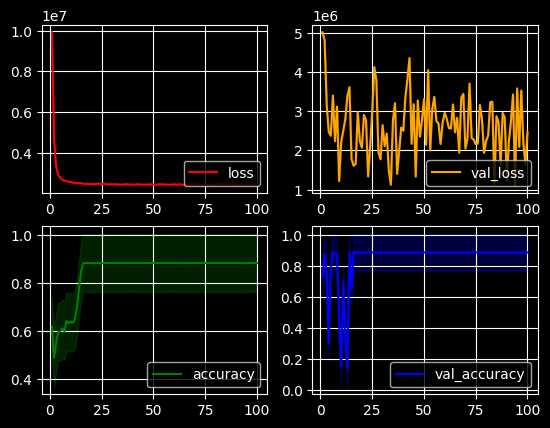

In [11]:
model_stats = [[np.asarray(model_history.history["loss"]), np.asarray(model_history.history["val_loss"])], 
          [np.asarray(model_history.history["accuracy"]), np.asarray(model_history.history["val_accuracy"])]]

def show_results(model_data):

    labels = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
    colors = [["red", "orange"], ["green", "blue"]]

    plt.style.use("dark_background")
    fig, axis = plt.subplots(nrows=2, ncols=2)
    for sample in range(len(axis)):

        axis[sample][0].plot(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0], color=colors[sample][0], label=labels[sample][0])
        axis[sample][0].fill_between(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0] - 0.12, model_stats[sample][0] + 0.12, color=colors[sample][0], alpha=0.25)
        
        axis[sample][1].plot(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1], color=colors[sample][1], label=labels[sample][1])
        axis[sample][1].fill_between(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1] - 0.12, model_stats[sample][1] + 0.12, color=colors[sample][1], alpha=0.25)

        axis[sample][0].legend(loc="lower right")
        axis[sample][0].grid()
        
        axis[sample][1].legend(loc="lower right")
        axis[sample][1].grid()

    plt.show()

show_results(model_data=model_stats)

In [12]:
test_max_data = 8000

test_data_buffer, test_person_buffer = data_loader(max_data=test_max_data, start_position=2000, base_dir=base_dir)

test_data_tensor = generate_data(data_buffer=test_data_buffer, max_from_samples=851)
prediction_data = test_data_tensor[:, :-1]
predicted_data_tensor = model.predict(prediction_data)

for (subject_number, subject_predicted_label) in enumerate(predicted_data_tensor):


    print(f"Subject: [{subject_number}] is chiter with probrability: [{subject_predicted_label}]")
    




269/269 [==============================] - 0s 955us/step
Subject: [0] is chiter with probrability: [[0.8878613]]
Subject: [1] is chiter with probrability: [[0.8873323]]
Subject: [2] is chiter with probrability: [[0.8868448]]
Subject: [3] is chiter with probrability: [[0.88528097]]
Subject: [4] is chiter with probrability: [[0.8842195]]
Subject: [5] is chiter with probrability: [[0.8852411]]
Subject: [6] is chiter with probrability: [[0.8882509]]
Subject: [7] is chiter with probrability: [[0.8880578]]
Subject: [8] is chiter with probrability: [[0.8886614]]
Subject: [9] is chiter with probrability: [[0.8880404]]
Subject: [10] is chiter with probrability: [[0.8828651]]
Subject: [11] is chiter with probrability: [[0.8839111]]
Subject: [12] is chiter with probrability: [[0.88812584]]
Subject: [13] is chiter with probrability: [[0.8900594]]
Subject: [14] is chiter with probrability: [[0.8828417]]
Subject: [15] is chiter with probrability: [[0.8879398]]
Subject: [16] is chiter with probrabili